In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env THEANO_FLAGS=device=gpu3,floatX=float32

env: THEANO_FLAGS=device=gpu3,floatX=float32


In [3]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *

import matplotlib.pyplot as plt
%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 3: Tesla K80 (CNMeM is enabled with initial size: 19.0% of memory, cuDNN 5110)


In [4]:
#!mkdir sasha_rnn 
# !wget https://www.dropbox.com/s/fxbjs8gebdm7lkv/sp.json?dl=0 -O sp.json
# !wget https://www.dropbox.com/s/ongjlpx798h8ysq/tinytitles.txt?dl=0 -O tinytitles.txt
# !wget https://www.dropbox.com/s/fqhq3v7h1d67e4e/tokens.txt?dl=0 -O tokens.txt
# !wget https://www.dropbox.com/s/l72wr3fqk3wio44/weights_persona.pcl?dl=0 -O weights_persona.pcl
# !wget https://www.dropbox.com/s/pfg0lx5c17r68tw/weights.pcl?dl=0 -O weights.pkl
# !wget https://www.dropbox.com/s/6igoxt5cji02m5e/names_new.txt?dl=0 -O names_new.txt

# data

In [5]:
NAMES_FILENAME = "names_new.txt"
TOKENS_FILENAME = "tokens.txt"

In [6]:
with open(NAMES_FILENAME) as fin:
    names = list(filter(len, fin.read().split('\n')))

In [7]:
names[:10]

['dr._oz',
 'human_wendy',
 'whoopi',
 'kkk_leader',
 'an_official',
 'woodsy_owl',
 'captain',
 'ozzy',
 'geraldo',
 'male_anchor']

In [8]:
with open(TOKENS_FILENAME) as fin:
    tokens = list(filter(len, fin.read().split('\n')))
tokens = tokens[:33646] + [name.strip('_').lower() for name in tokens[33646:]]   
tokens.append("_BOS_") #beginning of sentence. Omitted in danet
tokens.append("_PAD_") #padding. Omitted in danet

#tokens += names

UNK_ix, BOS_ix, EOS_ix, PAD_ix = list(map(tokens.index, ["_UNK_","_BOS_","_EOS_","_PAD_"]))
n_tokens = len(tokens)

from collections import defaultdict
token_to_ix = defaultdict(lambda : UNK_ix, {t:i for i, t in enumerate(tokens)})

In [9]:
name_to_ix = defaultdict(lambda : UNK_ix, {t:i for i, t in enumerate(names)})

In [10]:
import regex
import numpy as np

def preprocess(lines, max_len=20, speaker=None, add_eos=True):
    if type(lines) == (str):
        lines = [lines]
    
    context=[]
    for line in lines:
        line = line.lower()
        line = regex.sub(r'(\p{P}|`|~)', r' \1 ', line)
        line_ix = list(map(token_to_ix.__getitem__, filter(len, line.split())))
        if add_eos:
            line_ix.append(EOS_ix)
        context += line_ix
            
    if speaker is not None:
        context.append(speaker)
        
    return context

def ix_to_matrix(phrases_ix, max_len=None):
    max_len = max_len or max(map(len,phrases_ix))
    
    matrix = np.zeros((len(phrases_ix),max_len),dtype='int32') + PAD_ix
    
    for i,phrase_ix in enumerate(phrases_ix):
        matrix[i,:min(len(phrase_ix),max_len)] = phrase_ix[:max_len]
        
    return matrix

def phrase_to_matrix(contexts, max_len=None, **kwargs):
            
    return ix_to_matrix([preprocess(phrases,**kwargs) for phrases in contexts], max_len=max_len)

In [11]:
len(tokens)

36071

In [12]:
phrase_to_matrix(["Hello dude!!!"])

array([[13885, 34723,    14,    14,    14,     0]], dtype=int32)

# model

In [13]:
from warnings import warn
import numpy as np
import theano
theano.config.floatX='float32'
import theano.tensor as T

In [14]:
theano.config.exception_verbosity='high'

In [15]:
grad_clipping = 5
lstm_units = 1024
emb_size = 512
bottleneck_units = 256
person_emb_size = 100
seq_len = 20
sampling_num = 5

temperature = theano.shared(np.float32(1.))


In [16]:
from sasha_rnn.wrong_lstm_layer import WrongLSTMLayer
from lasagne.layers import *

class encoder:
        
    input_phrase = T.imatrix("encoder phrase tokens")
    
    l_in = InputLayer((None,None), input_phrase, name='context input')
    l_mask = InputLayer((None,None), T.neq(input_phrase, PAD_ix), 'context mask')
    
    l_emb = EmbeddingLayer(l_in, n_tokens, emb_size, name="context embedding")
    
    
    ####LSTMLayer with incorrect outputgate####
    
    l_lstm = WrongLSTMLayer(
                        l_emb,
                        lstm_units,
                        name='encoder_lstm',
                        grad_clipping=grad_clipping,
                        mask_input=l_mask,
                        only_return_final=True,
                        peepholes=False)
    
    output = l_lstm



In [17]:
n_persons = len(names)
person_id_var = T.ivector("personality idxs")
l_person_id = InputLayer((None,), person_id_var)
l_person_emb = EmbeddingLayer(l_person_id, n_persons, person_emb_size, name="persona_based.emb")

In [18]:
from sasha_rnn.wrong_lstm_cell import WrongLSTMCell
from agentnet import Recurrence
from agentnet.resolver import  ProbabilisticResolver

class decoder:
    prev_cell = InputLayer((None,lstm_units), name='cell')
    prev_out = InputLayer((None,lstm_units), name='out')
    
    
    
    #input
    inp_word = InputLayer((None,))
    word_embedding = EmbeddingLayer(inp_word, n_tokens, emb_size,
                                         W=encoder.l_emb.W, name='emb')
    encoder_lstm = InputLayer((None, lstm_units), name='encoder')
    person_emb = InputLayer((None, person_emb_size), name='persona_based.each_tick')
    #l_gumbel = InputLayer((None, person_emb_size), name='person_based_with_gumbel')

    #recurrent units
    new_cell,new_out = WrongLSTMCell(prev_cell, prev_out,
                                     input_or_inputs=[word_embedding, encoder_lstm, person_emb],
                                     name='decoder_lstm', peepholes=False
                                    )
    

    bottleneck = DenseLayer(new_out, bottleneck_units,
                              nonlinearity=T.tanh,
                              name='decoder intermediate')

    
    next_word_probs = DenseLayer(bottleneck, n_tokens,
                                 nonlinearity=lambda probs: T.nnet.softmax(probs/temperature),
                                 name='decoder next word probas')

    next_words = ProbabilisticResolver(next_word_probs, assume_normalized=True)
    
    



In [19]:
def get_mask_from_end_indicator(end_indicator):
    return T.concatenate([T.ones_like(end_indicator[:,:1]),
                          T.eq(T.cumsum(end_indicator,axis=1), 0)[:,:-1]], axis=1)

In [20]:
class generator:
    
    n_steps = T.iscalar()
    
    bos_input_layer = InputLayer((None,),T.zeros((encoder.input_phrase.shape[0],), 'int32')+BOS_ix, name="first input")

    recurrence = Recurrence(
                           input_nonsequences={decoder.encoder_lstm: encoder.output,
                                               decoder.person_emb: l_person_emb},
                           state_variables={decoder.new_cell: decoder.prev_cell,
                                            decoder.new_out: decoder.prev_out,
                                            decoder.next_words: decoder.inp_word},
                           tracked_outputs=[decoder.next_words, decoder.next_word_probs, decoder.new_cell, 
                                            decoder.new_out],
                           state_init={decoder.next_words: bos_input_layer},
                           n_steps=n_steps,
                           unroll_scan=False,)
    
    weights = get_all_params(recurrence, trainable=True)    
    
    rec_output = get_output(recurrence)

    out, probs, cell_seq, out_seq=rec_output[decoder.next_words],T.maximum(rec_output[decoder.next_word_probs],1e-10),\
                                               rec_output[decoder.new_cell], rec_output[decoder.new_out]
    
    mask = get_mask_from_end_indicator(T.eq(out, EOS_ix))
    auto_updates = recurrence.get_automatic_updates()
    
    generate = theano.function([encoder.input_phrase, person_id_var, n_steps], out,
                                updates=auto_updates)
    
    #Greedy mode
    greedy_out = get_output(recurrence[decoder.next_words], recurrence_flags={"greedy": True})
    
    greedy_auto_updates = recurrence.get_automatic_updates()
    greedy_mask = get_mask_from_end_indicator(T.eq(greedy_out, EOS_ix))
    
    generate_greedy = theano.function([encoder.input_phrase, person_id_var, n_steps], greedy_out,
                                       updates=greedy_auto_updates)
    
    # Perplexity 
    from agentnet.learning.generic import get_values_for_actions
    choosen_probs = get_values_for_actions(probs, out)
    perplexity = T.mean(T.power(2, -T.sum(T.log(choosen_probs), axis=-1) / n_steps))
    
    get_perplexity_fn = theano.function([encoder.input_phrase, person_id_var, n_steps], perplexity,
                                updates=auto_updates, allow_input_downcast=True)


    @staticmethod
    def reply(phrase, person_id, max_len=20, **kwargs):
        phrase_ix = phrase_to_matrix([phrase], **kwargs)
        answer_ix = generator.generate(phrase_ix, [person_id], max_len)[0]
        if EOS_ix in answer_ix:
            answer_ix = answer_ix[:list(answer_ix).index(EOS_ix)]
        return ' '.join(map(tokens.__getitem__, answer_ix))
    
    

In [ ]:
def generate_data(data_rows, batch_size=32, speakers_list=None, context_length=3, max_len=20, n_iter=np.inf):
    i=0

    while True:
        batch_ix = np.random.randint(0, len(data_rows) - context_length - 1, batch_size)
        context_ix = batch_ix[:, None] + np.arange(context_length)[None, :]
        answer_ix = batch_ix + context_length
        batch_x = ix_to_matrix(list(map(np.concatenate, data_rows[context_ix])), max_len=max_len)
        batch_y = ix_to_matrix(data_rows[answer_ix], max_len=max_len)
        if speakers_list == None:
            yield batch_x, batch_y
        else:
            respondent = speakers_list[answer_ix]
            yield batch_x, batch_y, respondent
        i+=1
        if i >= n_iter:
            break

In [ ]:
import json
from pprint import pprint

with open('sp.json', 'r') as fn:    
    data = json.load(fn, encoding='cp1251')
    
import re
numbers_regex = re.compile('#?[0-9]+')

def preprocess_speaker_name(name):
    try:
        str(name)
    except:
        return ''
    name_parts = map(str.lower, str(name).split())
    filtered = filter(lambda part: not re.match(numbers_regex, part), name_parts)
    return '_'.join(filtered)

data_rows = np.array([preprocess(lines=[phrase[1]])
                      for part in data for phrase in part['conversation'] if phrase[0] and phrase[1] 
                      and len(phrase[0]) > 2])

speakers_list = np.array([name_to_ix[preprocess_speaker_name(phrase[0][:-2])]
                      for part in data for phrase in part['conversation'] if phrase[0] and phrase[1] 
                          and len(phrase[0]) > 2])


In [52]:
one_batch = generate_data(data_rows, speakers_list=speakers_list, n_iter=1, max_len=seq_len).next()

/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [21]:
from agentnet.utils.persistence import save, load
#load(generator.recurrence, 'generator_ent_weights.pkl')

import pickle
with open("generator_ent_weights.pkl", 'rb') as f:
    d = pickle.load(f)

In [22]:
for i, param in enumerate(get_all_params(generator.recurrence)):
    if i == 0:
        param.set_value(d[15])
    elif i < 16:
        param.set_value(d[i - 1])
    else:
        param.set_value(d[i])

In [21]:
# import pickle
# with open("weights_persona.pcl", 'rb') as f:
#     d = pickle.load(f)
    
# d[0] = (np.random.normal(size=n_persons * person_emb_size).reshape((n_persons, person_emb_size)) * 1e-10).astype('float32')

In [22]:
# for i in range(1, len(d)):
#     if d[i].shape[0] == 100:
#         d[i] = (np.random.normal(size=(person_emb_size, d[i].shape[1]))* 1e-10).astype('float32')

In [24]:
emb_weights = d[0]

In [25]:
emb_weights.shape

(36071, 512)

In [25]:
from custom_layers import SrcTrgToMatrixLayer

class conv_discriminator:
#     questions_var = T.imatrix(name='questions var')
    reference_answers_var = T.imatrix(name = 'reference answers var')

    question = InputLayer((None, 20), name='question')
    answer = InputLayer((None, 20), name='answer')

    question_emb = EmbeddingLayer(question, emb_weights.shape[0], emb_weights.shape[1], W=emb_weights)
    answer_emb = EmbeddingLayer(answer, emb_weights.shape[0], emb_weights.shape[1], W=emb_weights)

    cnn_input = SrcTrgToMatrixLayer(question_emb, answer_emb)

    discr = BatchNormLayer(cnn_input)
    discr = Conv2DLayer(cnn_input, 20, (3, 3), nonlinearity=None)
    discr = Pool2DLayer(discr, (2, 2))
    discr = Conv2DLayer(discr, 20, (3, 3), nonlinearity=None)
    discr = Pool2DLayer(discr, (2, 2))
    discr = DenseLayer(discr, 20, nonlinearity=None)
    discr = DenseLayer(discr, 2, nonlinearity=lasagne.nonlinearities.softmax)
    
    output_on_fake = get_output(discr, {question: encoder.input_phrase, answer: generator.out})
    output_on_greedy_fake = get_output(discr, {question: encoder.input_phrase, answer: generator.greedy_out})
    output_on_real = get_output(discr, {question: encoder.input_phrase, answer: reference_answers_var})
    
    loss = -T.log(output_on_fake[:, 0]).sum() - T.log(output_on_real[:, 1]).sum()

    weights = get_all_params(discr, trainable=True)
    weights.remove(question_emb.W)
    weights.remove(answer_emb.W)

    updates = generator.auto_updates + lasagne.updates.adam(loss, weights, learning_rate=0.0001) 
    
    train_step = theano.function([encoder.input_phrase, reference_answers_var, person_id_var, generator.n_steps], loss, 
                                 updates=updates,
                                allow_input_downcast=True)

In [48]:
get_discr_out_on_fake = theano.function([encoder.input_phrase, person_id_var, generator.n_steps],
                                        conv_discriminator.output_on_fake[:, 1], updates=generator.auto_updates,
                                        allow_input_downcast=True)

get_discr_out_on_real = theano.function([encoder.input_phrase, conv_discriminator.reference_answers_var], 
                                        conv_discriminator.output_on_real[:, 1],
                                        allow_input_downcast=True)

In [54]:
test_discr_fn = theano.function([encoder.input_phrase, person_id_var, generator.n_steps], 
                                [generator.out, conv_discriminator.output_on_fake], updates=generator.auto_updates,
                               allow_input_downcast=True)

In [26]:
from agentnet.utils.persistence import save, load
load(conv_discriminator.discr, 'pretrain_batchconv_discr.pkl')

In [30]:
pretrain_discr_loss = []

In [31]:
#conv_discriminator.train_step(bx, by, respondent, 20)

In [ ]:
for bx, by in generate_data(data_rows, n_iter=10000, max_len=seq_len):
    err = conv_discriminator.train_step(bx, by, np.zeros(32, dtype='int32'), 20)
    pretrain_discr_loss.append(err)
    print("%.5f"%err)

13.19500
20.47677
16.31343
11.25036
13.79812
13.74212
13.97252
10.67869
12.83518
13.04411
8.92766
13.62577
19.43244
12.84212
11.13680
11.34190
20.45932
10.02649
17.87312
6.56907
15.55136
6.48747
11.90248
10.19146
8.48479
9.38074
12.21841
13.77382
15.65857
12.53300
9.18482
8.24759
12.30427
12.17761
11.02948
7.36431
9.69094
15.18881
15.88300
10.91526
18.82043
9.14221
12.25407
11.74377
9.93568
15.05332
8.29696
13.63016
10.59330
12.80749
15.64060
11.64354
15.24400
12.42552
11.55763
9.98370
11.00070
11.21354
11.14914
11.84945
16.32061
10.83476
14.78285
18.08160
12.64413
12.21265
14.67249
10.21734
16.39005
9.67547
13.22828
8.49753
9.64811
10.27160
11.47274
17.70840
12.19110
10.16042
8.42630
11.98774
18.57138
14.74045
9.14565
18.69499
17.94654
11.21513
14.83016
4.89813
13.93917
6.25328
19.16248
17.50181
14.60972
15.13255
12.52211
13.32636
9.16164
8.35065
17.27851
8.94913
12.85141
19.78357
13.88638
14.95810
10.45833
14.27289
17.41804
20.61655
8.69928
10.54044
10.76632
12.37820
12.02886
9.06219

In [41]:
def plot_smoothed(x, n=10):
    smoothed_x = [np.mean(x[i-n:i]) for i in range(n, len(x))]
    plt.plot(smoothed_x)
    

def phrase_from_idx(idxs, crop_by_eos=False):
    if crop_by_eos and EOS_ix in idxs:
        idxs = idxs[:list(idxs).index(EOS_ix)]
        
    phrase_tokens = map(tokens.__getitem__, idxs)
    return phrase_tokens

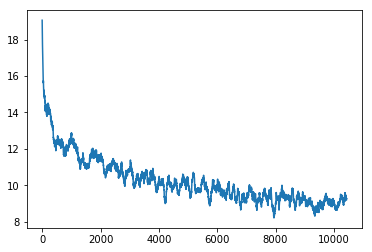

In [36]:
plot_smoothed(pretrain_discr_loss, n=100)

без обученных эмбеддингов имен:

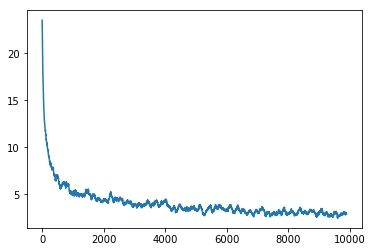

In [39]:
plot_smoothed(pretrain_discr_loss, n=100)

In [57]:
for i in range(10):
    name_id = 439
    name_batch =  phrase_to_matrix([["Hello", "Hello", "What is your name ? "]], max_len=20)
    gen_answer, gen_reward = test_discr_fn(name_batch, [name_id], 20)
    gen_answer = ' '.join(phrase_from_idx(gen_answer[0], crop_by_eos=True))
    print gen_reward[0, 1]
    print "GENERATED: ", gen_answer

0.405295
GENERATED:  my name is billy , and , where ' d you learn ? ! okay ! tell token what that
0.00136072
GENERATED:  my name is stanley , and i am the leader whole school .
0.00166306
GENERATED:  john edward , let me out of here ! ! you stupid little asshole !
0.00300377
GENERATED:  my name is randy marsh .
0.697447
GENERATED:  my name is stan marsh . i ' m from the future for my future self .
0.00226889
GENERATED:  my name is vivian .
0.768571
GENERATED:  my name is jimmy . i ' m a ' boy . i ' m a control school captain .
8.72313e-09
GENERATED:  my name is porsche .
0.000148391
GENERATED:  your brother is dead .
1.66831e-06
GENERATED:  mother !


In [72]:
# from agentnet.utils.persistence import save, load
# load(conv_discriminator.discr, 'pretrain_batchconv_discr.pkl')

In [96]:
# get_discr_out_on_fake = theano.function([encoder.input_phrase, person_id_var, generator.n_steps],
#                             conv_discriminator.output_on_fake[:, 1], updates=generator.recurrence.get_automatic_updates())

# get_discr_out_on_real = theano.function([encoder.input_phrase, conv_discriminator.reference_answers_var], conv_discriminator.output_on_real[:, 0])

In [62]:
from agentnet.learning.generic import get_values_for_actions

class pg_trainer:    
    
    rewards = conv_discriminator.output_on_fake[:, 1]
    baseline = conv_discriminator.output_on_greedy_fake[:, 1]

    advantage = rewards - baseline

    policy = get_values_for_actions(generator.probs, generator.out)
    #policy = T.maximum(policy, 1e-10)
    log_policy = T.log(policy)
    neg_entropy = (generator.probs * T.log(generator.probs)).sum(axis=-1)

    loss = ((-log_policy * advantage[:,None] + 0.01 * neg_entropy) * generator.mask).sum() / generator.mask.sum()

    grads = T.grad(loss, generator.weights)
    grads = lasagne.updates.total_norm_constraint(grads, 10)

    updates = generator.auto_updates + generator.greedy_auto_updates
    updates += lasagne.updates.adam(grads, generator.weights, learning_rate=1e-3) 

    train_step = theano.function([encoder.input_phrase, person_id_var, generator.n_steps], loss,
                                 updates=updates,
                                 allow_input_downcast=True)

In [49]:
def phrase_from_idx(idxs, crop_by_eos=False):
    if crop_by_eos and EOS_ix in idxs:
        idxs = idxs[:list(idxs).index(EOS_ix)]
        
    phrase_tokens = map(tokens.__getitem__, idxs)
    return phrase_tokens

In [65]:
name_batch =  phrase_to_matrix([["Hello", "Hello", "What is your name ? "]], max_len=20)

conversation_names = set(names) & set(tokens)

conversation_name_idxs = map(name_to_ix.get, conversation_names)
conversation_token_idxs = map(token_to_ix.get, conversation_names)

name_batch_repeated = np.repeat(name_batch, len(conversation_names), axis=0)

def accuracy_in_names():
    #model_answers = generator.generate(name_batch_repeated, conversation_name_idxs, 20, latent_for_name_batch)
    model_answers = [generator.generate(name_batch, [name_idx], 20) 
                                        for name_idx in conversation_name_idxs]
    def crop_by_eos(answer):
        if  EOS_ix in answer:
            return answer[:list(answer).index(EOS_ix)]
        return answer
        
    res = map(lambda answer, name_idx: name_idx in set(crop_by_eos(answer[0])), model_answers, conversation_token_idxs)   
    matched_idxs = np.where(res)[0]
    name_idxs = [conversation_name_idxs[idx] for idx in matched_idxs]
    matched_names = [names[idx] for idx in name_idxs]
    
    matched_answers = [' '.join(phrase_from_idx(model_answers[idx][0], crop_by_eos=True)) for idx in matched_idxs] 
    return matched_names, matched_answers
    return sum(res)

In [66]:
gen_train_errors = []
discr_train_errors = []

In [67]:
for epoch in range(200):
    for _ in range(1):
        for bx, by, respondent in generate_data(data_rows, speakers_list=speakers_list, n_iter=2, max_len=seq_len):
            err = pg_trainer.train_step(bx, respondent, 20)
            gen_train_errors.append(err)
        #print("Gen %.5f"%err)
    for _ in range(6):
        for bx, by, respondent in generate_data(data_rows, speakers_list=speakers_list, n_iter=15, max_len=seq_len):
            err = conv_discriminator.train_step(bx, by, respondent, 20)
            discr_train_errors.append(err)
        #print("Discr %.5f"%err)
#     if not epoch % 10:
#         acc = accuracy_in_names()
#         print "Accuracy ", acc
#         accuracies_in_names.append(acc)

/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


KeyboardInterrupt: 

 Без обученных эмбеддингов имен:

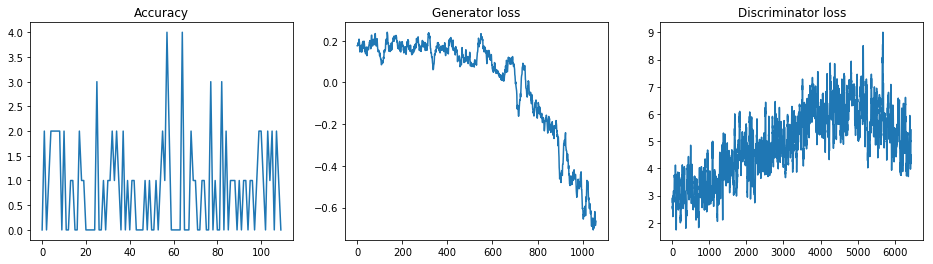

In [85]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.title("Accuracy")
plt.plot(accuracies_in_names);
plt.subplot(1, 3, 2)
plt.title("Generator loss")
plot_smoothed(gen_train_errors, n=20)

plt.subplot(1, 3, 3)
plt.title("Discriminator loss")
plot_smoothed(discr_train_errors, n=20)

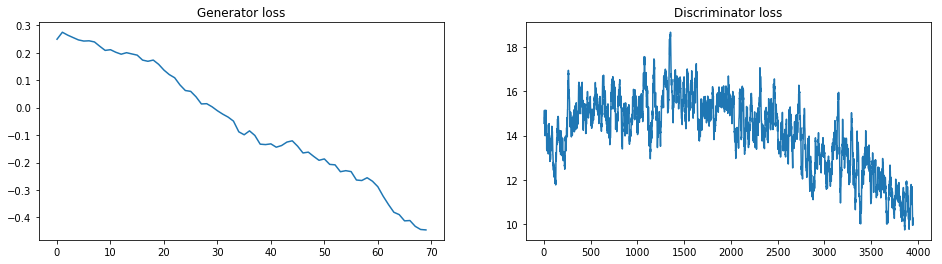

In [68]:
plt.figure(figsize=(16, 4))
# plt.subplot(1, 3, 1)
# plt.title("Accuracy")
# plt.plot(accuracies_in_names);
plt.subplot(1, 2, 1)
plt.title("Generator loss")
plot_smoothed(gen_train_errors, n=20)

plt.subplot(1, 2, 2)
plt.title("Discriminator loss")
plot_smoothed(discr_train_errors, n=20)

In [69]:
temperature.set_value(np.float32(0.5))
for i in range(5):
    print(generator.reply(["Hello!", "Hello", "What is your name ?"], 1))
    
temperature.set_value(np.float32(1))

my name is roma . but the f - word is " shit " on national television called " the
kyle broflovski , have a seat with the f - word of god , mister marsh . a man from
my name is token . and i live by a name like this one thing , and a girl named
howdy ho . eh yes ? my god , kyle . and i have a black friend named bernie ,
my name is elise - nn - ca - _UNK_ . i ' m a man as a name .


In [83]:
temperature.set_value(np.float32(0.5))
for i in range(5):
    print(generator.reply(["Hello!", "Hello", "What is your name ?"], 1))
    
temperature.set_value(np.float32(1))

i ' m danny _UNK_ .
your name is _UNK_ , i ' m a real man , i ' m a _UNK_ boy , i
i ' m alexander _UNK_
i ' m myles _UNK_ .
_UNK_ , my friend , a friend of mine


### Adversarial success

In [73]:
accuracy_in_names()

(['m', 'man', 'timmy', 'kenny', 'pip'],
 ["ooo stan marsh . a what are his name kyle gints ? i ' m sure as soon as filmore",
  'hi fellas . i wanna go home . y - you gotta come meet the white man . get your',
  'boooo ! ! show us what senator spears ? ! fudge said , timmy timmy timmy russell fan flying disciprine',
  '# and daddy my fat ugly little woman ! whoa whoa whoa whoa , whoa h . . . kenny',
  "eugh . uhuh , i ' m pip kids from my future ' s voice box salesman , travis harrisons"])

In [72]:
generator.get_perplexity_fn(one_batch[0], one_batch[2], 20)

array(13.866877423254387)

In [45]:
import pickle
with open('test_batches.pcl', 'rb') as f:
    test_batches = pickle.load(f)

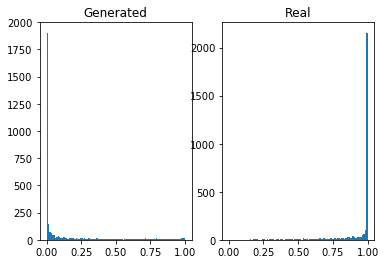

In [49]:
outs = []
real_outs = []
for bx, by, respondent in test_batches:
    outs.append(get_discr_out_on_fake(bx, respondent, 20))
    real_outs.append(get_discr_out_on_real(bx, by))
outs = np.concatenate(outs)
real_outs = np.concatenate(real_outs)

plt.subplot(1, 2, 1)
plt.title("Generated")
plt.hist(outs, bins=100);
plt.subplot(1, 2, 2)
plt.title("Real")
plt.hist(real_outs, bins=100);

In [50]:
from sklearn.metrics import roc_auc_score
roc_auc_score(len(outs) * [0] + len(real_outs) * [1], np.concatenate([outs, real_outs]))

0.97704047851562503

In [56]:
gen_answers, gen_rewards = test_discr_fn(one_batch[0], one_batch[2], 20)
gen_answers = [' '.join(phrase_from_idx(gen_answers[j], crop_by_eos=True)) for j in range(len(one_batch[1]))]
answers =  [' '.join(phrase_from_idx(one_batch[1][j], crop_by_eos=True)) for j in range(len(one_batch[1]))]
discr_reward = gen_rewards[:, 1]

for i in range(one_batch[0].shape[0]):
    print discr_reward[i]
    print ' '.join(phrase_from_idx(one_batch[0][i]))
    print "REAL: ", answers[i]
    print "GENERATED: ", gen_answers[i]

0.559551
ooo , psych ! _EOS_ she must be back at the train station ; come on ! _EOS_ now ,
REAL:  son , you don ' t seem to understand . britney spears . . . has to die .
GENERATED:  sorry , wendy , what ' s funny about that ?
0.00170529
no , dammit ! i ' m talking about the zombies that have taken over south park ! _EOS_ well
REAL:  well , let ' s get back to it .
GENERATED:  stay back ! we ' ll use another yay !
2.49756e-05
succubus trying to take my baby ! _EOS_ come on cartman ! _EOS_ i can ' t see anything !
REAL:  ( wait . . . )
GENERATED:  ( help is there . )
3.95905e-06
oh yeah , my evel knievel doll ! _EOS_ mr . mackey , i realize this might be fun for
REAL:  excuse me , i really need to get back to my sheep .
GENERATED:  uh . . . sorry .
0.000221779
dammit billy , do you want a dollar or don ' t ya ? _EOS_ sure . _EOS_ ok .
REAL:  i ' m not gonna kill you grampa .
GENERATED:  go away , nathan ! and i ' m gonna tell travis !
0.804367
i need your help ! _EOS_ no , you just have

## Stuff

In [ ]:
from agentnet.learning.generic import get_values_for_actions

class conv_log_gan_trainer:    
    
    rewards = T.log(conv_discriminator.output_on_fake[:, 1])
    baseline = T.log(conv_discriminator.output_on_greedy_fake[:, 1])

    advantage = rewards - baseline

    policy = T.maximum(generator.probs, 1e-10)
    log_policy = T.log(policy)
    
    #policy gradient
    J = log_policy * advantage[:,None]
    
    loss = -J.mean()
    
    
    #regularize with negative entropy
    entropy = -T.sum(policy * log_policy, axis=-1)

    loss -= 0.01 * entropy.mean()

    grads = T.grad(loss, generator.weights)
    grads = lasagne.updates.total_norm_constraint(grads, 10)

    updates = lasagne.updates.adam(grads, model.weights, learning_rate=1e-5) 

    train_step = theano.function([encoder.input_sequence],loss,
                                 updates = model.auto_updates+model.greedy_auto_updates+updates)

In [120]:
actions, policy = generator.out[:, :-1], generator.probs[:, :-1]
policy = T.maximum(policy, 1e-10)

def one_step_reward(step_idx, gen_out):
    return get_output(conv_discriminator.discr, 
                                            {conv_discriminator.question: encoder.input_phrase,
                                             conv_discriminator.answer: gen_out[:, :step_idx+1], 
                                          })[:, 1]

def one_step_reward_and_value(step_idx, gen_out):
    assert False, "Implement me"
    #output_on_fake = get_output(discr, {question: encoder.input_phrase, answer: generator.out})
    #output_on_real = get_output(discr, {question: encoder.input_phrase, answer: reference_answers_var})
    curr_reward, state_value = get_output([conv_discriminator.l_prob, baseline_discriminator.l_prob], 
                                            {discriminator.l_in: generator.out[:, :step_idx+1], 
                                            discriminator.l_mask: get_mask_from_end_indicator(
                                                                       T.eq(generator.out[:, :step_idx+1], EOS_ix)),
                                           baseline_discriminator.l_in: gen_out[:, :step_idx+1], 
                                            baseline_discriminator.l_mask: get_mask_from_end_indicator(
                                                                           T.eq(gen_out[:, :step_idx+1], EOS_ix))
                                          })
    
    return (curr_reward[:, 1], state_value[:, 1])

In [125]:
rewards, scan_updates = theano.scan(one_step_reward, sequences=[theano.tensor.arange(seq_len)],
                                       non_sequences=[actions])
rewards = rewards.T[:, :-1]


In [126]:
from agentnet.learning import reinforce

reinforce_loss = reinforce.get_elementwise_objective(policy, actions, rewards).mean()
gen_updates = lasagne.updates.adam(reinforce_loss, generator.weights, learning_rate=0.001)
train_pg_step = theano.function([encoder.input_phrase, person_id_var, generator.n_steps],
                                rewards.mean(), updates=generator.recurrence.get_automatic_updates() + gen_updates,
                              allow_input_downcast=True)

In [110]:
bx.shape, by.shape, respondent.shape

((32, 20), (32, 20), (32,))

In [24]:
class trainer:
    reference_answers = T.imatrix("decoder reference answers")
    
    bos_column = T.zeros((reference_answers.shape[0], 1), 'int32') + BOS_ix
    reference_answers_bos = T.concatenate((bos_column, reference_answers), axis=1)  #prepend BOS
        
    l_ref = InputLayer((None, None), reference_answers_bos, name='context input')
    l_ref_mask = InputLayer((None,None), T.neq(reference_answers_bos, PAD_ix), 'context mask')

    recurrence = Recurrence(input_sequences={decoder.inp_word:l_ref},
                           input_nonsequences={decoder.encoder_lstm:encoder.output,
                                               decoder.person_emb:l_person_emb},
                           state_variables={decoder.new_cell:decoder.prev_cell,
                                            decoder.new_out:decoder.prev_out,},
                           tracked_outputs=[decoder.next_word_probs],
                           mask_input=l_ref_mask,
                           unroll_scan=False,)
    
    
    P_seq = get_output(recurrence[decoder.next_word_probs])
    #V_seq = whateveryouadded
    
    ############################
    ###loglikelihood training###
    ############################
    predicted_probas = P_seq[:, :-1].reshape((-1, n_tokens)) + 1e-6
    target_values = reference_answers.ravel()

    llh = lasagne.objectives.categorical_crossentropy(predicted_probas, target_values)
    llh_loss = llh.mean()
    llh_updates = lasagne.updates.adam(llh_loss, generator.weights, 0.001)

    train_llh_step = theano.function([encoder.input_phrase, person_id_var, reference_answers],
                                     llh_loss, updates=llh_updates, allow_input_downcast=True)
    get_llh = theano.function([encoder.input_phrase, person_id_var, reference_answers], llh_loss,
                             allow_input_downcast=True)
    

In [24]:
#data_rows = np.array(list(map(preprocess, open("./titles.txt").read().split('\n'))))

### Stuff

In [51]:
name_to_ix['Mother']

1266

In [52]:
mother_phrases_idxs = []
for i, idx in enumerate(speakers_list):
    if idx == 1266:
        mother_phrases_idxs.append(i)

In [53]:
mother_phrases_idxs

[3079,
 3082,
 3084,
 6993,
 9316,
 25085,
 25089,
 26662,
 26664,
 26666,
 26668,
 26670,
 26675,
 48338,
 48340,
 60755,
 62422,
 72981,
 72983,
 74786]

In [54]:
np.array(mother_phrases_idxs) - 3

array([ 3076,  3079,  3081,  6990,  9313, 25082, 25086, 26659, 26661,
       26663, 26665, 26667, 26672, 48335, 48337, 60752, 62419, 72978,
       72980, 74783])

In [55]:
mother_contexts = [[data_rows[idx-3], data_rows[idx-2], data_rows[idx-1]] for idx in mother_phrases_idxs]

In [57]:
temperature.set_value(0.5)
for i in range(len(mother_contexts)):
    phrases = [' '.join(map(tokens.__getitem__, mother_contexts[i][j])) for j in range(3)]
    print 'CONTEXT'
    for j in range(3):
        print phrases[j]
    print 'ANSWER'
    print 'OUR:', generator.reply(phrases, 1266)
    print 'REAL:', ' '.join(map(tokens.__getitem__, data_rows[mother_phrases_idxs[i]]))

CONTEXT
_UNK_ . could you have them turn up the light s a little , please ? [ the waiter goes away ] _EOS_
oh , look at it , gerald . all the new families moving in . [ a new mexican restaurant - _UNK_ _UNK_ - is having its grand opening across the street ] our little town is all grown up . _EOS_
where ' s that other taco plate ? we need it now . _EOS_
ANSWER
OUR: you want us to tell you what we want to do ?
REAL: i ' m a little overwhelmed . _EOS_
CONTEXT
i ' m a little overwhelmed . _EOS_
i know . but we ' ve put everything into moving here and starting this business , and we have to be impressive . [ walks up to the boy and gets down on one knee ] _UNK_ , you must help your mama however you can . we ' re not going back to that miserable place ! _EOS_
i don ' t wanna go back either . _EOS_
ANSWER
OUR: i ' m not sure .
REAL: okay , done . _EOS_
CONTEXT
i don ' t wanna go back either . _EOS_
okay , done . _EOS_
great ! [ rises and goes for the plates ] we really have to impress this cu

In [628]:
temperature.set_value(0.5)
for i in range(len(mother_contexts)):
    phrases = [' '.join(map(tokens.__getitem__, mother_contexts[i][j])) for j in range(3)]
    print 'CONTEXT'
    for j in range(3):
        print phrases[j]
    print 'ANSWER'
    print 'OUR:', generator.reply(phrases, 1266)
    print 'REAL', ' '.join(map(tokens.__getitem__, data_rows[mother_phrases_idxs[i]]))

CONTEXT
_UNK_ . could you have them turn up the light s a little , please ? [ the waiter goes away ] _EOS_
oh , look at it , gerald . all the new families moving in . [ a new mexican restaurant - _UNK_ _UNK_ - is having its grand opening across the street ] our little town is all grown up . _EOS_
where ' s that other taco plate ? we need it now . _EOS_
ANSWER
OUR: hey , you can ' t just leave the kids alone . it ' s the last time i came
REAL i ' m a little overwhelmed . _EOS_
CONTEXT
i ' m a little overwhelmed . _EOS_
i know . but we ' ve put everything into moving here and starting this business , and we have to be impressive . [ walks up to the boy and gets down on one knee ] _UNK_ , you must help your mama however you can . we ' re not going back to that miserable place ! _EOS_
i don ' t wanna go back either . _EOS_
ANSWER
OUR: what ? clyde ? clyde ? clyde ? clyde ? timmy ! you have to come out of the closet
REAL okay , done . _EOS_
CONTEXT
i don ' t wanna go back either . _EOS_
oka

In [ ]:
temperature.set_value(0.5)
for i in range(len(mother_contexts)):
    phrases = [' '.join(map(tokens.__getitem__, mother_contexts[i][j])) for j in range(3)]
    print 'CONTEXT'
    for j in range(3):
        print phrases[j]
    print 'ANSWER'
    print 'OUR:', generator.reply(phrases, 1266)
    print 'REAL', ' '.join(map(tokens.__getitem__, data_rows[mother_phrases_idxs[i]]))

In [615]:
data_rows[mother_phrases_idxs]

array([[14726, 20, 18026, 501, 17596, 21478, 19, 0],
       [21005, 11, 9040, 19, 0], [1648, 21063, 16, 0],
       [1, 11, 33406, 11, 4475, 10, 0],
       [20971, 12744, 11, 16499, 11, 14299, 19, 0], [28501, 16, 0],
       [28501, 16, 0], [0], [20971, 645, 29290, 11, 10417, 8960, 19, 0],
       [20971, 14299, 32704, 33467, 20205, 15711, 501, 19655, 651, 29541, 19, 0],
       [32627, 11, 32704, 20, 25698, 29957, 19723, 651, 30032, 15024, 29957, 33159, 16, 0],
       [0], [1528, 32736, 33467, 20, 24193, 9040, 31664, 29972, 0],
       [501, 17818, 20924, 22094, 4926, 29957, 12546, 12374, 1528, 9026, 20, 29407, 16710, 19, 0],
       [20971, 33406, 11, 9518, 21063, 20924, 29972, 20, 25698, 501, 3492, 19, 0],
       [32704, 1885, 30015, 8981, 16, 0], [13955, 7782, 19, 0],
       [33406, 16, 0], [33406, 11, 31917, 20, 25698, 1970, 27800, 19, 0],
       [21814, 29972, 33481, 19, 0]], dtype=object)